# ALL IMPORTS

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import chi2_contingency
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm

## Loading in dataset...

In [ ]:
student_mat = pd.read_table('/home/ics-home/Pearson Proj/Pearson/datasets/student-mat.csv', sep=";")

In [ ]:
# Taking a quick look
print(student_mat)

## 1. Initial look at the dataframe

**Histograms for Quantitative Variables**

In [ ]:
# Can make individual ones or one for each numeric column
# x-axis is the value and y-axis is the count
student_mat.hist(bins=20, figsize=(15, 10), color='green', alpha=0.5)
plt.suptitle('Histograms for All Numeric Columns in Math df')
plt.show()

## 2. Visualising Categorical and Quantitaive Vars. vs G3

**i. Boxplots for Categorical Variables vs G3**

In [ ]:
# List of Categorical Variables in Math df
cat_vars = [
    'sex', 'school', 'address', 
    'Pstatus', 'Mjob', 'Fjob', 
    'guardian', 'famsize', 'reason', 
    'schoolsup', 'famsup', 'activities', 
    'paid', 'internet', 'nursery', 
    'higher', 'romantic'
]

for cat_var in cat_vars:
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=student_mat, x=cat_var, y='G3')
    plt.title(f"G3 by {cat_var}")
    plt.xlabel(f"{cat_var}")
    plt.ylabel('G3')
    plt.show()

**ii. Bar Graphs for Quantitative Variables vs G3**

In [ ]:
# List of Numerical Vars in Math df
quan_vars = [
    "age", "Medu", "Fedu", "famrel", "traveltime", "studytime", "failures", 
    "freetime", "goout", "Walc", "Dalc", "health", "absences", "G1", "G2"
]

for quan_var in quan_vars:
    g3_means = student_mat.groupby(quan_var)['G3'].mean()
    g3_means.plot(kind='bar', title=f"Average G3 Score by {quan_var}", figsize=(8,5))
    plt.xlabel(f"{quan_var}")
    plt.ylabel('Average G3 Score')
    plt.show()

**ii. Boxplots for Quantitaive Variables vs. G3**

In [ ]:
for quan_var in quan_vars:
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=student_mat, x=quan_var, y='G3')
    plt.title(f"G3 by {quan_var}")
    plt.xlabel(f"{quan_var}")
    plt.ylabel('G3')
    plt.show()

## 3. Picking vars to focus on

## 4a. Chi-Square Tests on Categorical Vars

***For categorical variables, needed to change the G3 scores from integers to letter grades for chi-square test.***

In [ ]:
# Function to assign letter grades
def assign_grade(score):
    if 16 <= score <= 20:
        return 'A'
    elif 14 <= score <= 15:
        return 'B'
    elif 12 <= score <= 13:
        return 'C'
    elif 10 <= score <= 11:
        return 'D'
    else:
        return 'F'

# Apply function to each grading period
for col, letter_col in zip(["G1", "G2", "G3"], ["L1", "L2", "L3"]):
    student_mat[letter_col] = student_mat[col].apply(assign_grade)

In [ ]:
# Function for running chi-square test
def perform_chi_square_test(data, col1, col2):
    # creating contingency table
    contingency_table = pd.crosstab(data[col1], data[col2])

    # performing the chi-square test
    chi2, p, dof, expected = chi2_contingency(contingency_table)

    # interpreting the result
    significant = p < 0.05 #5% significance level
    return chi2, p, significant

In [ ]:
# Categorical Vars of Interest
cat_vars_to_test = {
    "Student's School and Academic Performance": ('school', 'L2'),
    "Student's Address and Academic Performance": ('address', 'L2'),
    "Internet Access and Academic Performance": ('internet', 'L2'),
    "Mother's Job and Academic Performance": ('Mjob', 'L1'),
    "Father's Job and Academic Performance": ('Fjob', 'L1'),
    "School Support and Academic Performance": ('schoolsup', 'L3'),
    "Desire for Higher Education and Academic Performance": ('higher', 'L3')
}

results = {aspect: perform_chi_square_test(student_mat, *columns) for aspect, columns in cat_vars_to_test.items()}
chi_square_results = pd.DataFrame(results)
chi_square_results

## 4b. T-Tests on Quantitative Vars

In [ ]:
# Quantitaive Vars of Interest
quan_vars_focus = [
    'age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'health', 'G1', 'G2'
]

In [ ]:
G3_median = student_mat['G3'].median()
student_mat['G3_median'] = student_mat['G3'].apply(lambda x: 'low' if x < G3_median else 'high')

results = []
for quan_var in quan_vars_focus:
    low = student_mat[student_mat['G3_median'] == 'low'][quan_var]
    high = student_mat[student_mat['G3_median'] == 'high'][quan_var]

    t_stat, p_value = stats.ttest_ind(low, high, equal_var = False)

    results.append({"Variable": quan_var, "T-test": t_stat, "P-value": p_value})

ttest_results = pd.DataFrame(results)
ttest_results.sort_values("P-value")

ttest_results['Statistically Significant'] = ttest_results['P-value'] < 0.05
ttest_results.sort_values('Statistically Significant')

# Linear Regression w/ "Naive Model"

**1. Split the data randomly into training (75%) and testing (25%) sets**

In [ ]:
# List of variables we want to focus on (based on visuals and tests)
cat_vars = ['Mjob', 'Fjob', 'schoolsup', 'higher']
quan_vars = ['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'G1', 'G2']

# Make a subset of the variables we want to focus on
cat_vars_df = student_mat[cat_vars]
quan_vars_df = student_mat[quan_vars]

grade = student_mat['G3']

# set seed using random_state = 4 to make reproduceable
num_train, num_test, grade_train, grade_test = train_test_split(quan_vars_df, grade, random_state = 4)
cat_train, cat_test, grade_train, grade_test = train_test_split(cat_vars_df, grade, random_state = 4)

**2. With training data, fit linear regression models**

**3. With testing data, compute RMSE**

### MIGHT WANT TO USE BARPLOTS SINCE MOST THE VARIABLES (CATEGORICAL AND QUANTITAIVE) ARE DISCRETE

### ONLY G1 AND G2 ARE CONTINUOUS

***Categorical Models***

In [ ]:
# Dictionary to store results
results = {}

# Create subplots for each categorical variable
fig, axes = plt.subplots(nrows=len(cat_vars), ncols=1, figsize=(8, 5 * len(cat_vars)))

if len(cat_vars) == 1:
    axes = [axes]  # Ensure axes is iterable for a single variable

for i, cat_var in enumerate(cat_vars):
    # One-hot encode the categorical variable
    encoder = OneHotEncoder(drop='first', sparse_output=False)
    cat_train_encoded = encoder.fit_transform(cat_train[[cat_var]])
    cat_test_encoded = encoder.transform(cat_test[[cat_var]])

    # Convert to DataFrame
    cat_train_df = pd.DataFrame(cat_train_encoded, columns=encoder.get_feature_names_out([cat_var]))
    cat_test_df = pd.DataFrame(cat_test_encoded, columns=encoder.get_feature_names_out([cat_var]))

    # Train Linear Regression model
    cat_model = LinearRegression()
    cat_model.fit(cat_train_df, grade_train)

    # Predictions
    y_pred = cat_model.predict(cat_test_df)

    # Calculate RMSE instead of MSE
    rmse = np.sqrt(mean_squared_error(grade_test, y_pred))
    results[cat_var] = rmse
    print(f"Model with {cat_var}: RMSE = {rmse:.4f}")

    # Convert categorical variable to numeric encoding for plotting
    label_encoder = LabelEncoder()
    cat_test_numeric = label_encoder.fit_transform(cat_test[cat_var])

    # Sort values for proper trendline
    sorted_indices = np.argsort(cat_test_numeric)
    sorted_x = cat_test_numeric[sorted_indices]
    sorted_y = y_pred[sorted_indices]

    # Plot regression line
    axes[i].plot(sorted_x, sorted_y, color="red", linewidth=2)
    axes[i].set_title(f'Linear Regression for {cat_var} (RMSE={rmse:.4f})')
    axes[i].set_xlabel(cat_var)
    axes[i].set_ylabel('Predicted Grades')
    axes[i].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
for cat_var in cat_vars:
    plt.figure(figsize=(8, 5))

    # Ensure df_results includes the categorical variable
    df_results = pd.DataFrame({
        "Actual": grade_test.values,
        "Predicted": y_pred,
        cat_var: cat_test[cat_var].values  # Add categorical variable
    })

    # Group by categorical variable and compute mean
    grouped_results = df_results.groupby(cat_var)[["Actual", "Predicted"]].mean()

    # Plot bar chart
    grouped_results.plot(kind="bar", ax=plt.gca(), colormap="coolwarm")

    plt.title(f'Average Actual vs. Predicted Grades for {cat_var}')
    plt.ylabel('Grade')
    plt.xlabel(cat_var)
    plt.xticks(rotation=45)
    plt.legend(["Actual", "Predicted"])

    plt.show()

***Quantitative Models***

In [ ]:
# Create subplots for each quantitative variable
fig, axes = plt.subplots(nrows=len(quan_vars), ncols=1, figsize=(8, 5 * len(quan_vars)))

if len(quan_vars) == 1:
    axes = [axes]  # Ensure axes is iterable for a single variable

for i, quan_var in enumerate(quan_vars):
    # Extract the predictor (X) and response (y)
    X_train = num_train[[quan_var]].values  # Reshape for sklearn
    X_test = num_test[[quan_var]].values
    y_train = grade_train.values
    y_test = grade_test.values

    # Train Linear Regression model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Predictions
    y_pred = model.predict(X_test)

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"Model with {quan_var}: RMSE = {rmse:.4f}")

    # Scatter plot + regression line
    sns.regplot(x=X_test.flatten(), y=y_test, scatter=True, ax=axes[i], 
                line_kws={"color": "red", "linewidth": 2})  # Red regression line

    # Customize plot
    axes[i].set_title(f'Linear Regression for {quan_var} (RMSE={rmse:.4f})')
    axes[i].set_xlabel(quan_var)
    axes[i].set_ylabel("Actual Grades (G3)")
    axes[i].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# Exclude 'G1' and 'G2' from quantitative variables list
quan_vars_filtered = [var for var in quan_vars if var not in ['G1', 'G2']]

# Create bar plots for each remaining variable
for quan_var in quan_vars_filtered:
    plt.figure(figsize=(8, 5))

    # Ensure df_results includes the categorical variable
    df_results = pd.DataFrame({
        "Actual": grade_test.values,
        "Predicted": y_pred,
        quan_var: num_test[quan_var].values  # Add variable to group by
    })

    # Calculate the mean of actual vs predicted grades for each level of the variable
    grouped_results = df_results.groupby(quan_var)[["Actual", "Predicted"]].mean()

    # Plot bar chart
    grouped_results.plot(kind="bar", ax=plt.gca(), colormap="coolwarm")

    plt.title(f'Average Actual vs. Predicted Grades for {quan_var}')
    plt.ylabel('Grade')
    plt.xlabel(quan_var)
    plt.xticks(rotation=45)
    plt.legend(["Actual", "Predicted"])

    plt.show()

## Side Quest: Train a linear regression model using all features (both quantitative and categorical)

***Getting RMSE with all features***

In [256]:
# Combine quantitative and categorical data into one DataFrame
combined_df = pd.concat([quan_vars_df, cat_vars_df], axis=1)

# One-Hot Encode the categorical variables
encoder = OneHotEncoder(drop='first', sparse_output=False)
cat_vars_encoded = encoder.fit_transform(cat_vars_df)

# Convert the encoded features back to DataFrame
cat_vars_encoded_df = pd.DataFrame(cat_vars_encoded, columns=encoder.get_feature_names_out(cat_vars_df.columns))

# Combine the one-hot encoded categorical features with the quantitative features
combined_df_encoded = pd.concat([quan_vars_df, cat_vars_encoded_df], axis=1)

# Split the data into training and test sets
X_train, X_test, grade_train, grade_test = train_test_split(combined_df_encoded, grade, random_state=4)

# Train the model using all features (both quantitative and categorical)
model = LinearRegression()
model.fit(X_train, grade_train)

# Make predictions
y_pred = model.predict(X_test)

# Compute RMSE
rmse = np.sqrt(mean_squared_error(grade_test, y_pred))
print(f"RMSE for the model with all features: {rmse:.4f}")

RMSE for the model with all features: 1.8084


In [ ]:
print(r2_score(grade_test, y_pred))

***Plotting with all features***

In [ ]:
# Scatter plot of actual vs predicted grades
plt.figure(figsize=(8, 5))
plt.scatter(grade_test, y_pred, color='blue', alpha=0.5, label="Predictions vs Actual")

# Plotting the ideal line where predictions equal actual values (y=x line)
plt.plot([grade_test.min(), grade_test.max()], [grade_test.min(), grade_test.max()], color='red', linestyle='--', label="Ideal (y=x)")

# Customize plot
plt.xlabel('Actual Grades (G3)')
plt.ylabel('Predicted Grades')
plt.title('Predicted vs Actual Grades (Model with All Features)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Linear Regression w/ "Smarter Model"

**1. Forwards Selection Method**

Added G2, New RMSE: 1.8072
Added failures, New RMSE: 1.7840
Added G1, New RMSE: 1.7690
Added schoolsup_yes, New RMSE: 1.7513
Added studytime, New RMSE: 1.7406
Added traveltime, New RMSE: 1.7388
Added Fjob_teacher, New RMSE: 1.7370
Added Mjob_teacher, New RMSE: 1.7369


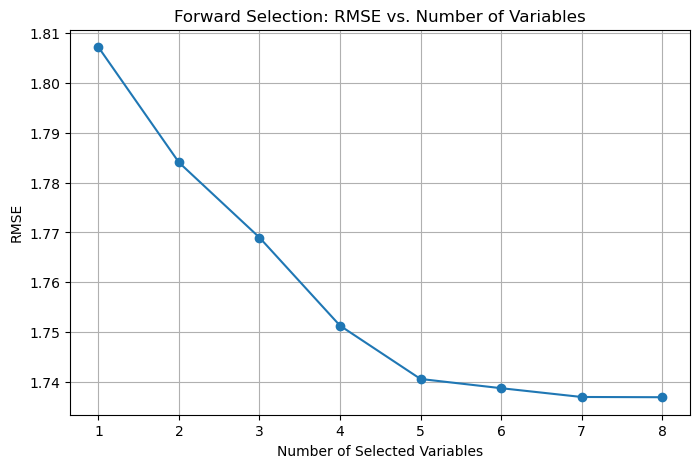

                            OLS Regression Results                            
Dep. Variable:                     G3   R-squared:                       0.808
Model:                            OLS   Adj. R-squared:                  0.803
Method:                 Least Squares   F-statistic:                     151.4
Date:                Mon, 03 Mar 2025   Prob (F-statistic):           2.71e-98
Time:                        18:47:02   Log-Likelihood:                -619.69
No. Observations:                 296   AIC:                             1257.
Df Residuals:                     287   BIC:                             1291.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -1.6676      0.621     -2.685

In [255]:
# Extract numerical features
quan_vars_df = student_mat[quan_vars]

# Extract categorical features
cat_vars_df = student_mat[cat_vars]

# One-hot encode categorical variables using OneHotEncoder
encoder = OneHotEncoder(drop='first', sparse_output=False)  
cat_encoded = encoder.fit_transform(cat_vars_df)  
cat_encoded_df = pd.DataFrame(cat_encoded, columns=encoder.get_feature_names_out(cat_vars_df.columns))

# Concatenate numerical and encoded categorical variables
X = pd.concat([quan_vars_df, cat_encoded_df], axis=1)

# Define target variable
y = student_mat['G3']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=4)

def forward_selection_with_plot(X_train, y_train, X_test, y_test):
    # Initializing variables
    remaining_vars = list(X_train.columns)  # All available predictors
    selected_vars = []  # Empty list to store selected vars
    best_model = None  # Placeholder for the best model
    lowest_rmse = float("inf")  # Start with the highest possible RMSE
    rmse_list = []  # To store RMSE values at each step
    step_list = []  # Stores step count

    while remaining_vars:  # Loops until no more variables
        rmse_dict = {}
        for var in remaining_vars:  # Iterate through each var not yet selected
            model_vars = selected_vars + [var]  # Try adding one new var
            X_train_selected = sm.add_constant(X_train[model_vars])  # Test the var added
            X_test_selected = sm.add_constant(X_test[model_vars])

            model = sm.OLS(y_train, X_train_selected).fit()
            y_pred = model.predict(X_test_selected)
            rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            rmse_dict[var] = rmse  # Store RMSE for this variable
        
        best_var = min(rmse_dict, key=rmse_dict.get)  # Choose best var to add
        best_rmse = rmse_dict[best_var]

        # Check if model improved
        if best_rmse < lowest_rmse:
            selected_vars.append(best_var)  # Keep this variable
            remaining_vars.remove(best_var)  # Remove it from remaining variables
            lowest_rmse = best_rmse  # Update best RMSE
            best_model = sm.OLS(y_train, sm.add_constant(X_train[selected_vars])).fit()  # Update model
            rmse_list.append(best_rmse)
            step_list.append(len(selected_vars))
            print(f"Added {best_var}, New RMSE: {best_rmse:.4f}")
        else:
            break  # Stop if no more improvements, prevents overfitting

    # Plot RMSE vs. Number of Variables Selected
    plt.figure(figsize=(8,5))
    plt.plot(step_list, rmse_list, marker='o', linestyle='-')
    plt.xlabel("Number of Selected Variables")
    plt.ylabel("RMSE")
    plt.title("Forward Selection: RMSE vs. Number of Variables")
    plt.grid(True)
    plt.show()
    
    return best_model, selected_vars

# Run forward selection
best_forward_model, selected_forward_vars = forward_selection_with_plot(X_train, y_train, X_test, y_test)
print(best_forward_model.summary())

**2. Backwards Selection Model**

In [ ]:
def backward_selection_with_plot(X_train, y_train, X_test, y_test, p_threshold=0.05):
    selected_vars = list(X_train.columns)
    rmse_list = []  # Track RMSE
    step_list = []  # Track step number

    while len(selected_vars) > 0:
        X_train_selected = sm.add_constant(X_train[selected_vars])
        X_test_selected = sm.add_constant(X_test[selected_vars])
        
        model = sm.OLS(y_train, X_train_selected).fit()
        y_pred = model.predict(X_test_selected)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        
        rmse_list.append(rmse)
        step_list.append(len(selected_vars))

        p_values = model.pvalues[1:]  # Exclude intercept
        worst_var = p_values.idxmax()
        worst_pval = p_values.max()

        if worst_pval > p_threshold:
            print(f"Removing {worst_var} (p-value={worst_pval:.4f})")
            selected_vars.remove(worst_var)
        else:
            break

    # Plot RMSE vs. Number of Remaining Variables
    plt.figure(figsize=(8,5))
    plt.plot(step_list, rmse_list, marker='o', linestyle='-')
    plt.xlabel("Number of Remaining Variables")
    plt.ylabel("RMSE")
    plt.title("Backward Selection: RMSE vs. Number of Variables")
    plt.grid(True)
    plt.show()

    final_model = sm.OLS(y_train, sm.add_constant(X_train[selected_vars])).fit()
    return final_model, selected_vars

best_backward_model, selected_backward_vars = backward_selection_with_plot(X_train, y_train, X_test, y_test)
print(best_backward_model.summary())


***Plotting...***

In [ ]:
def plot_predictions(model, X_test, y_test, selected_vars, title):
    X_test_selected = sm.add_constant(X_test[selected_vars])
    y_pred = model.predict(X_test_selected)

    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.6, label="Predictions")
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color="red", linestyle="--", label="Perfect Fit")
    
    plt.xlabel("Actual Grades (G3)")
    plt.ylabel("Predicted Grades (G3)")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

# Forward selection model predictions
plot_predictions(best_forward_model, X_test, y_test, selected_forward_vars, "Forward Selection: Predicted vs Actual")

# Backward selection model predictions
plot_predictions(best_backward_model, X_test, y_test, selected_backward_vars, "Backward Selection: Predicted vs Actual")

**3. Stepwise Selection Model**

In [ ]:
def stepwise_selection(X_train, y_train, X_test, y_test, direction='both'):
    """
    Perform stepwise selection based on RMSE.
    direction: 'forward', 'backward', or 'both'
    """
    initial_features = X_train.columns.tolist()
    selected_features = []
    best_model = None
    lowest_rmse = float('inf')  # Start with a very high RMSE

    while True:
        changed = False
        
        # Forward Selection
        if direction in ['forward', 'both']:
            remaining_features = [f for f in initial_features if f not in selected_features]
            for feature in remaining_features:
                model = sm.OLS(y_train, sm.add_constant(X_train[selected_features + [feature]])).fit()
                y_pred = model.predict(sm.add_constant(X_test[selected_features + [feature]]))
                rmse = np.sqrt(mean_squared_error(y_test, y_pred))

                if rmse < lowest_rmse:
                    lowest_rmse = rmse
                    best_model = model
                    selected_features.append(feature)
                    changed = True
                    print(f"Added {feature}, New RMSE: {rmse:.4f}")

        # Backward Elimination
        if direction in ['backward', 'both']:
            for feature in selected_features:
                temp_features = selected_features.copy()
                temp_features.remove(feature)
                model = sm.OLS(y_train, sm.add_constant(X_train[temp_features])).fit()
                y_pred = model.predict(sm.add_constant(X_test[temp_features]))
                rmse = np.sqrt(mean_squared_error(y_test, y_pred))

                if rmse < lowest_rmse:
                    lowest_rmse = rmse
                    best_model = model
                    selected_features.remove(feature)
                    changed = True
                    print(f"Removed {feature}, New RMSE: {rmse:.4f}")

        # If no changes were made, stop the procedure
        if not changed:
            break
    
    # Print final RMSE on the test set
    print(f"Final RMSE on test set: {lowest_rmse:.4f}")

    # Plot RMSE over time (number of features selected)
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(selected_features) + 1), [lowest_rmse] * len(selected_features), marker='o', linestyle='-')
    plt.xlabel("Number of Features Selected")
    plt.ylabel("RMSE")
    plt.title("Stepwise Selection: RMSE vs. Number of Features")
    plt.grid(True)
    plt.show()

    return best_model, selected_features

# Run the stepwise selection using RMSE as the criterion
best_stepwise_model, selected_stepwise_vars = stepwise_selection(X_train, y_train, X_test, y_test, direction='both')
print(best_stepwise_model.summary())

In [ ]:
plot_predictions(best_stepwise_model, X_test, y_test, selected_stepwise_vars, "Stepwise Selection: Predicted vs Actual")